# XGboost Prediction of TdF scores

XGBoost implements the gradient boosting decision tree alogrithm. I choose this algorithm because I have heard good stories about this algorithm regarding to Kaggle competitions. In these stories, they praise the speed and performance of the algorithm. Therefore, I wanted to learn to use it. 

Boosting is an ensemble technique where new models are added to correct the errors made by the existing models. Since XGBoost is based on trees, the new models that are added are trees. And XGBoost adds one tree at a time. Then it uses gradient descent to minimize the loss when adding new models.

Note: Not all Tour de France teams have given up their team yet. Therefore, current predictions are made for 2019, which is also nice since it can be used to see if the model works properly.

In [1]:
# import
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
#years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,2018, 2019]
# Open up the features for each year in a dataframe and add it to a list so they can be concatenated.
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,2018]
df_files = ['features_' + str(year) + '.csv' for year in years]
features_dfs = []
for df_file in df_files:
    features_dfs.append(pd.read_csv(df_file, delimiter=';'))

In [3]:
features_dfs[5].head(5)

,Unnamed: 0,rider,PCS,Team,Age,Nationality,Team PCS,flat1-4,flat5-8,flat9-12,...,mountains(flat)1-4,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule
0,0,rider/christopher-froome,1377,Team Sky,29,Great Britain,4172,1.0,0.0,2.0,...,1.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0,1.0,7.0
1,1,rider/bernhard-eisel,185,Team Sky,33,Austria,4172,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,2,rider/vasil-kiryienka,417,Team Sky,33,Belarus,4172,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,10.0
3,3,rider/david-lopez,176,Team Sky,33,Spain,4172,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,4,rider/mikel-nieve,604,Team Sky,30,Spain,4172,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0


In [4]:
# Concatenate the dataframes and delete unwanted columns
data_df = pd.concat(features_dfs)
# Remove unnamed column
data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
# Remove rows that either have PCS, or age as None
data_df = data_df[data_df['PCS'] != 'None']
data_df = data_df[data_df['Age'] != 'None']
# Change datatypes
data_df = data_df.astype({"PCS": int, "Age": int})

## Normalize the wielerpoule score

In [5]:
# Function to min-max normalize a dataframe column
def min_max_normalization(column):
  min_score = column.min()
  max_score = column.max()
  normalized = (column - min_score) / (max_score - min_score)
  return normalized, min_score, max_score

In [6]:
# Min-max the wielerpoule column which has to be predicted
data_df['wielerpoule'], min_score, max_score = min_max_normalization(data_df['wielerpoule'])

(array([1474.,  243.,   89.,   52.,   25.,   23.,    9.,    8.,    6.,
           3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

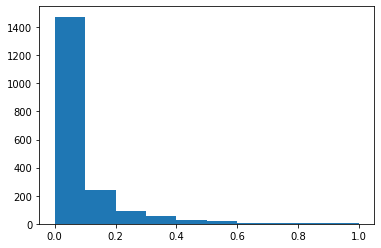

In [7]:
plt.hist(data_df['wielerpoule'])

In [8]:
# Drop columns that are not used as features
columns_to_drop = ['rider', 'Team', 'Nationality']
cleaned_data_df = data_df.drop(columns_to_drop, axis=1).reset_index(drop=True)

# Divide the data in test (20%) and training (80%)
train_df = cleaned_data_df.sample(frac=0.8, random_state=420)
test_df = cleaned_data_df.drop(train_df.index)

In [9]:
train_df.head(5)

,PCS,Age,Team PCS,flat1-4,flat5-8,flat9-12,hills(flat)1-4,hills(flat)5-8,hills(flat)9-12,hills(uphill)1-4,...,mountains(flat)1-4,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule
204,56,30,4325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1315,93,30,2362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007092
184,102,27,3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
760,180,39,3953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
194,362,26,6445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000


In [10]:
test_df.head(5)

,PCS,Age,Team PCS,flat1-4,flat5-8,flat9-12,hills(flat)1-4,hills(flat)5-8,hills(flat)9-12,hills(uphill)1-4,...,mountains(flat)1-4,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule
2,249,29,4358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.035461
3,68,32,4358,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,1474,31,4358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
6,250,33,4358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
9,1824,32,3682,1.0,0.0,2.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0,0.156028


In [11]:
# Set up the labels
y_train = train_df['wielerpoule']
y_test = test_df['wielerpoule']

In [12]:
# Drop wielerpoule score as feature
train_df = train_df.drop('wielerpoule', axis=1)
test_df = test_df.drop('wielerpoule', axis=1)

In [13]:
# Quick check if data is split correctly
print(len(data_df))
print(len(train_df))
print(len(test_df))

1932
1546
386


In [14]:
# Load the data in a XGBoost datamatrix
dtrain = xgb.DMatrix(train_df, label=y_train)
dtest = xgb.DMatrix(test_df, label=y_test)

In [15]:
# specifity parameters via map, using the example generalized_linear_model
param = {'objective': 'reg:squarederror', 'booster':'gblinear', 'alpha': 0.0001,'lambda':1}
progress = dict()
num_round = 50
watchlist  = [(dtrain,'train-rmse'), (dtest, 'eval-rmse')]
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=progress)

[0]	train-rmse-rmse:0.16843	eval-rmse-rmse:0.16297
[1]	train-rmse-rmse:0.13375	eval-rmse-rmse:0.13421
[2]	train-rmse-rmse:0.11850	eval-rmse-rmse:0.12111
[3]	train-rmse-rmse:0.11098	eval-rmse-rmse:0.11389
[4]	train-rmse-rmse:0.10618	eval-rmse-rmse:0.10944
[5]	train-rmse-rmse:0.10275	eval-rmse-rmse:0.10592
[6]	train-rmse-rmse:0.10019	eval-rmse-rmse:0.10327
[7]	train-rmse-rmse:0.09832	eval-rmse-rmse:0.10105
[8]	train-rmse-rmse:0.09666	eval-rmse-rmse:0.09945
[9]	train-rmse-rmse:0.09530	eval-rmse-rmse:0.09801
[10]	train-rmse-rmse:0.09427	eval-rmse-rmse:0.09684
[11]	train-rmse-rmse:0.09349	eval-rmse-rmse:0.09608
[12]	train-rmse-rmse:0.09274	eval-rmse-rmse:0.09527
[13]	train-rmse-rmse:0.09221	eval-rmse-rmse:0.09467
[14]	train-rmse-rmse:0.09194	eval-rmse-rmse:0.09439
[15]	train-rmse-rmse:0.09156	eval-rmse-rmse:0.09388
[16]	train-rmse-rmse:0.09120	eval-rmse-rmse:0.09350
[17]	train-rmse-rmse:0.09092	eval-rmse-rmse:0.09325
[18]	train-rmse-rmse:0.09070	eval-rmse-rmse:0.09303
[19]	train-rmse-rmse:0

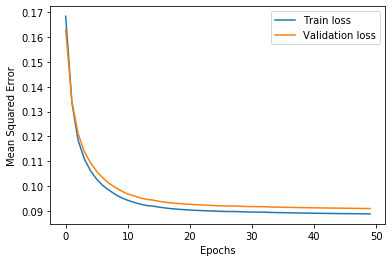

In [16]:
# Plot the train and validation loss
np_loss = np.asarray(progress['train']['rmse-rmse'])
np_val_loss = np.asarray(progress['eval']['rmse-rmse'])
plt.plot(np_loss, label='Train loss')
plt.plot(np_val_loss, label='Validation loss')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.show()

## Predict the 2020 scores

I have to wait untill the teams are complete. Therefore, below are the scores for 2019. What suprises me, is that the top riders come quit close to the ones that performed best!

In [17]:
# Open features to predict
predict_filename = 'features_2019.csv'
predict_df = pd.read_csv(predict_filename, delimiter=';')
# Remove unnamed column
predict_df = predict_df.loc[:, ~predict_df.columns.str.contains('^Unnamed')]
# Change datatypes
predict_df = predict_df.astype({"PCS": int, "Age": int})

In [18]:
# Remove unwanted features
columns_to_drop = ['rider', 'Team', 'Nationality', 'wielerpoule']
cleaned_predict_df = predict_df.drop(columns_to_drop, axis=1)

In [19]:
# Add data to XGBoost datamatrix
dpredict = xgb.DMatrix(cleaned_predict_df)

In [20]:
# Predict the score
predictions = bst.predict(dpredict)

In [21]:
# reverse the normalization and add the predicted score to the dataframe
predict_df['predicted_score'] = predictions * (max_score - min_score) + min_score

In [22]:
# Sort the rows based on the predicted score
predict_df.sort_values(by='predicted_score', ascending=False)

,rider,PCS,Team,Age,Nationality,Team PCS,flat1-4,flat5-8,flat9-12,hills(flat)1-4,...,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule,predicted_score
16,rider/julian-alaphilippe,2265,Deceuninck - Quick Step,27,France,7715,3.0,0.0,0.0,9.0,...,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,89.0,67.592903
23,rider/elia-viviani,1863,Deceuninck - Quick Step,30,Italy,7715,6.0,2.0,1.0,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,59.425972
1,rider/egan-bernal,1991,Team INEOS,22,Colombia,5612,1.0,2.0,2.0,0.0,...,1.0,1.0,5.0,1.0,1.0,4.0,0.0,0.0,78.0,59.197182
128,rider/caleb-ewan,1592,Lotto Soudal,25,Australia,5481,9.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,56.282494
56,rider/jakob-fuglsang,2183,Astana Pro Team,34,Denmark,5955,1.0,0.0,0.0,7.0,...,3.0,0.0,2.0,2.0,0.0,4.0,1.0,1.0,11.0,52.542660
67,rider/dylan-groenewegen,1326,Team Jumbo-Visma,26,Netherlands,6360,13.0,3.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,72.0,49.674088
8,rider/peter-sagan,1614,BORA - hansgrohe,29,Slovakia,5227,1.0,4.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,45.875469
88,rider/greg-van-avermaet,1847,CCC Team,34,Belgium,2940,1.0,0.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,39.0,45.028805
49,rider/alejandro-valverde,2230,Movistar Team,39,Spain,5603,0.0,2.0,0.0,2.0,...,0.0,1.0,9.0,3.0,1.0,5.0,0.0,1.0,22.0,44.049946
86,rider/matteo-trentin,1572,Mitchelton-Scott,30,Italy,5597,5.0,1.0,1.0,12.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,55.0,40.870697


In [216]:
# Dan is het alleen nog de predicted score / waarde vd renner en dan krijg je punten per waarde.